<a href="https://colab.research.google.com/github/buchijw/Long_ML_Course/blob/main/7_Molecular_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rdkit-pypi tdqm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 33 kB/s 
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1319 sha256=6ca05cc46dd9f3d0a1dc996da3638732b11a8907c788437088d6711b362b2d97
  Stored in directory: /root/.cache/pip/wheels/c6/f0/d9/9fa5ff78c0f9d5a0a427bbbb4893c283520ddfccb885ea2205
Successfully built tdqm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Number of molecules in dataset: 4635


molecule_chembl_id                               smiles      pIC50  \
0        CHEMBL63786    Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1  11.522879   
1        CHEMBL35820  CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC  11.221849   
2        CHEMBL53711   CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1  11.221849   
3        CHEMBL66031  Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1  11.096910   
4        CHEMBL53753      CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1  11.096910   

                                            Molecule  
0  <img data-content="rdkit/molecule" src="data:i...  
1  <img data-content="rdkit/molecule" src="data:i...  
2  <img data-content="rdkit/molecule" src="data:i...  
3  <img data-content="rdkit/molecule" src="data:i...  
4  <img data-content="rdkit/molecule" src="data:i...
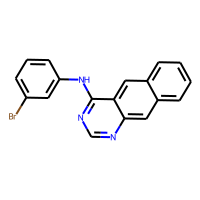
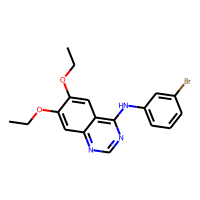
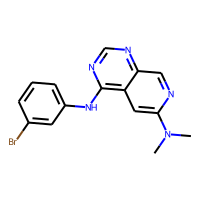
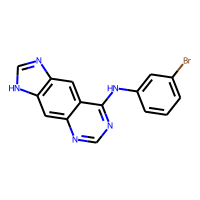
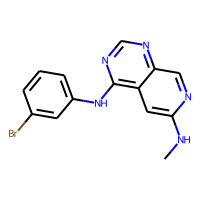

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from rdkit.Chem import PandasTools
import IPython
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools, AllChem
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect
from rdkit.Chem.Draw import IPythonConsole #RDKit drawing => visualize
tqdm.pandas()
df = pd.read_csv("/content/drive/MyDrive/MedAI/1. Chemoinformatics/Data/EGFR_compounds_lipinski.csv",
    usecols=["molecule_chembl_id", "smiles", "pIC50"],
)
print(f"Number of molecules in dataset: {len(df)}")
PandasTools.AddMoleculeColumnToFrame(df,'smiles','Molecule',includeFingerprints=False)
df.head(5)

# **1. Molecular similarity**
Once the descriptors/fingerprints are calculated, they can be compared to assess the similarity between two molecules. Molecular similarity can be quantified with a number of different similarity coefficients, two common similarity measures are the Tanimoto and Dice index ([<i>J. Med. Chem.</i> (2014), <b>57</b>, 3186-3204](http://pubs.acs.org/doi/abs/10.1021/jm401411z)).

In [ ]:
import seaborn as sns
base = "CN1C=C(C2=CC=CC=C21)C3=NC(=NC=C3)NC4=C(C=C(C(=C4)NC(=O)C=C)N(C)CCN(C)C)OC" # query 
#data.drop(index = 1504, inplace = True)
query = Chem.MolFromSmiles(base)
query.SetProp('_Name',"Osimertinib")
circular_fp_query = GetMorganFingerprintAsBitVect(query, 2, nBits=1024)
circular_fp_query

In [ ]:
from rdkit import Chem, DataStructs
PandasTools.AddMoleculeColumnToFrame(df, smilesCol = 'smiles')
def mol2fp(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) 
    return fp
df["ecfp4"] = df.ROMol.progress_apply(mol2fp)
circular_fp_list = df["ecfp4"].tolist()

  0%|          | 0/4635 [00:00<?, ?it/s]

## 1.1. Tanimoto coefficient

$$T _{c}(A,B) = \frac{c}{a+b-c}$$

- a: number of features present in molecule A 
- b: number of features present in molecule B 
- c: number of features shared by molecules A and B

molecule_chembl_id                               smiles      pIC50  \
0        CHEMBL63786    Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1  11.522879   
1        CHEMBL35820  CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC  11.221849   
2        CHEMBL53711   CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1  11.221849   

                                            Molecule  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   

                                               ROMol  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   

                                               ecfp4  tanimoto_ecfp  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       0.139785  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       0.156250  
2  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...       0.156250
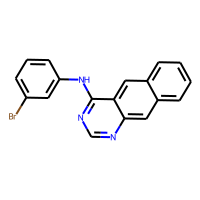
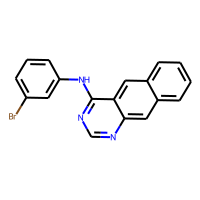
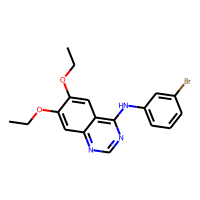
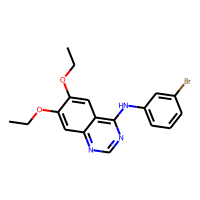
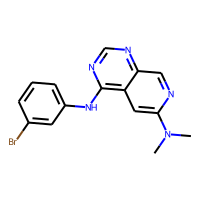
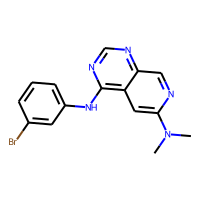

In [ ]:
df["tanimoto_ecfp"] = DataStructs.BulkTanimotoSimilarity(circular_fp_query, circular_fp_list)
df.head(3)

## 1.2. Dice coefficient

$$D_{c}(A,B) = \frac{c}{\frac{1}{2}(a+b)}$$

- a: number of features present in molecule A
- b: number of features present in molecule B 
- c: number of features shared by molecules A and B

The similarity measures usually consider the number of positive bits (1's) present in either fingerprint and the number of positive bits that both have in common. 
Dice similarity usually returns higher values than Tanimoto similarity because of their denominators:

$$\frac{c}{a+b-c} \leq \frac{c}{\frac{1}{2}(a+b)}$$

molecule_chembl_id                               smiles      pIC50  \
0        CHEMBL63786    Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1  11.522879   
1        CHEMBL35820  CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC  11.221849   
2        CHEMBL53711   CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1  11.221849   

                                            Molecule  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   

                                               ROMol  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   

                                               ecfp4  tanimoto_ecfp  dice_ecfp  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       0.139785   0.245283  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       0.156250   0.270270  
2  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...       0.156250   0.270270
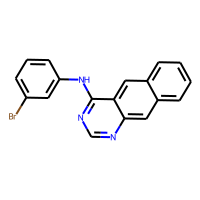
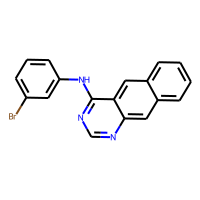
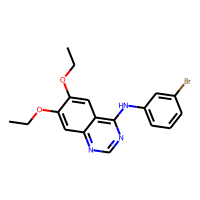
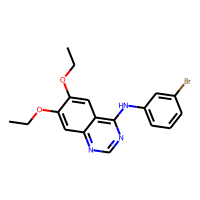
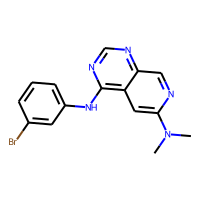
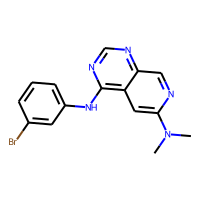

In [ ]:
df["dice_ecfp"] = DataStructs.BulkDiceSimilarity(circular_fp_query, circular_fp_list)
df.head(3)

## 1.3. Tversky coefficient

$$T _{c}(A,B) = \frac{c}{a+b-c}$$

- a: number of features present in molecule A 
- b: number of features present in molecule B 
- c: number of features shared by molecules A and B

$\alpha$
$\beta$

molecule_chembl_id                               smiles      pIC50  \
0        CHEMBL63786    Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1  11.522879   
1        CHEMBL35820  CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC  11.221849   
2        CHEMBL53711   CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1  11.221849   

                                            Molecule  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   

                                               ROMol  \
0  <img data-content="rdkit/molecule" src="data:i...   
1  <img data-content="rdkit/molecule" src="data:i...   
2  <img data-content="rdkit/molecule" src="data:i...   

                                               ecfp4  tanimoto_ecfp  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       0.139785   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...       0.156250   
2  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...       0.156250   

   dice_ecfp  Tversky_ecfp  
0   0.245283      0.245283  
1   0.270270      0.270270  
2   0.270270      0.270270
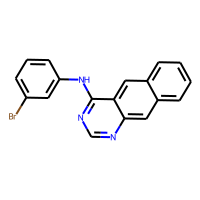
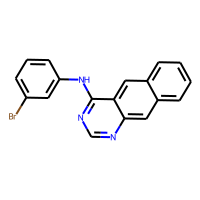
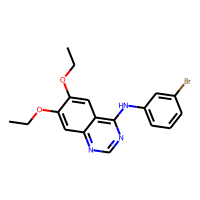
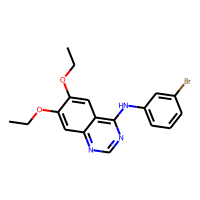
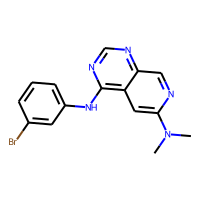
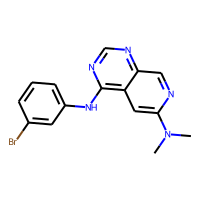

In [ ]:
df["Tversky_ecfp"] = DataStructs.BulkTverskySimilarity(circular_fp_query, circular_fp_list, 0.5, 0.5)
df.head(3)

# **2. Visualize**

(array([   5.,   53.,  271.,  912., 1037., 1036.,  927.,  348.,   38.,
           8.]),
 array([ 1.60205999,  2.59414187,  3.58622374,  4.57830562,  5.57038749,
         6.56246937,  7.55455124,  8.54663312,  9.53871499, 10.53079687,
        11.52287875]),
 <a list of 10 Patch objects>)

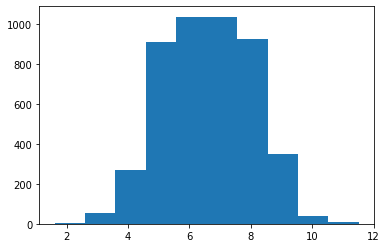

In [ ]:
plt.hist(df.pIC50)

In [ ]:
df = df[['pIC50', "tanimoto_ecfp", "dice_ecfp", "Tversky_ecfp",]]

In [ ]:
# Add column for activity
df["active"] = np.zeros(len(df))

# Mark every molecule as active with an pIC50 of >= 8, 0 otherwise
df.loc[df[df.pIC50 >= 8].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(df.active.sum()))
print("Number of inactive compounds:", len(df) - int(df.active.sum()))

Number of active compounds: 906
Number of inactive compounds: 3729


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

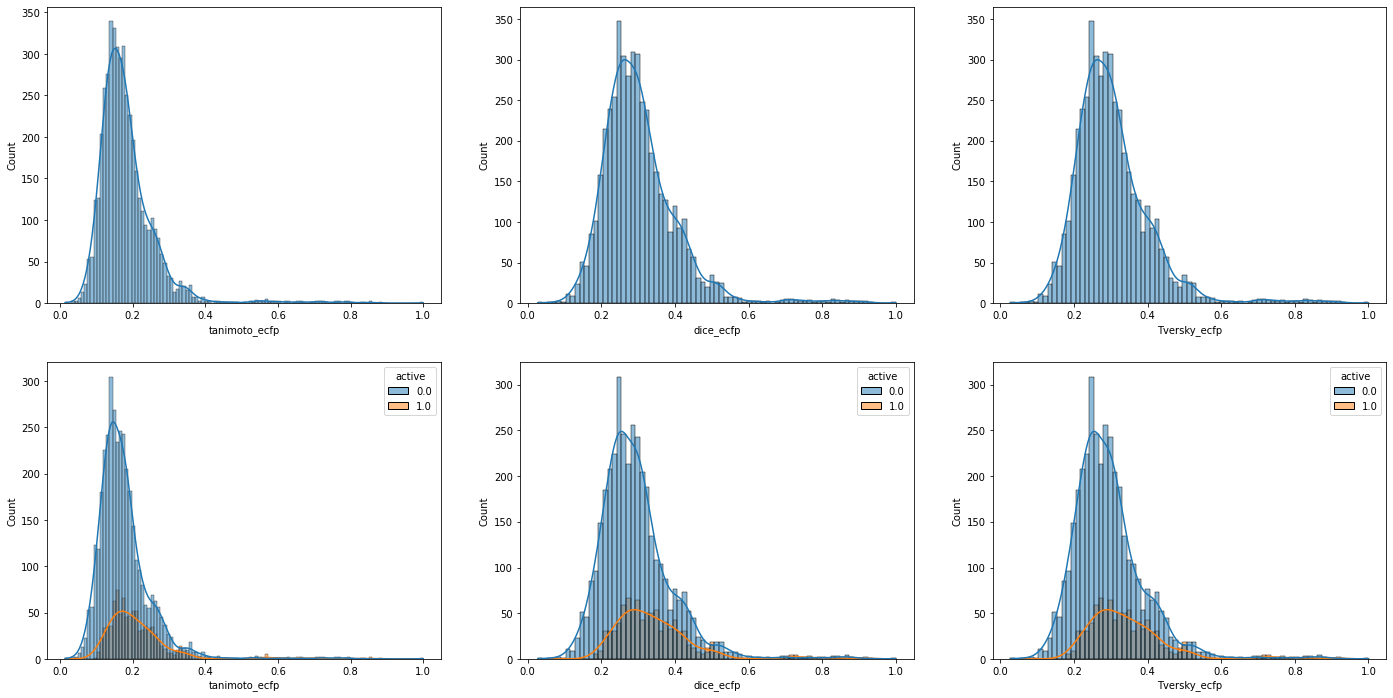

In [ ]:
fig, axes = plt.subplots(figsize=(24, 12), nrows=2, ncols=3)

sns.histplot(data = df, x=df["tanimoto_ecfp"], ax=axes[0, 0], kde = True, )
sns.histplot(data = df, x=df["dice_ecfp"], ax=axes[0, 1],kde = True, )
sns.histplot(data = df, x=df["Tversky_ecfp"],ax=axes[0, 2],kde = True,)

sns.histplot(data = df, x=df["tanimoto_ecfp"],hue=df["active"], ax=axes[1, 0], kde = True, )
sns.histplot(data = df, x=df["dice_ecfp"],hue=df["active"], ax=axes[1, 1],kde = True, )
sns.histplot(data = df, x=df["Tversky_ecfp"], hue=df["active"],ax=axes[1, 2],kde = True,)

# **3. Similarity Map**

https://greglandrum.github.io/rdkit-blog/tutorial/2020/01/03/similarity-maps-with-new-drawing-code.html


The normalized weights are then used to color the atoms in a topography-like map with green indicating a positive difference (i.e. the similarity or probability decreases when the bits are removed) and pink indicating a negative difference, gray represents no change.

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import SimilarityMaps
from IPython.display import SVG
import io
from PIL import Image
import numpy as np
import rdkit
print(rdkit.__version__)

2022.03.5


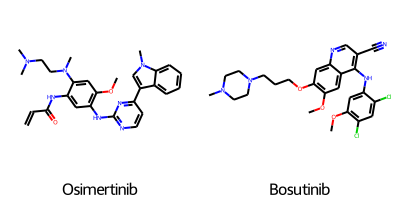

In [ ]:
Osimertinib = query
Bosutinib = Chem.MolFromSmiles("CN1CCN(CC1)CCCOC2=C(C=C3C(=C2)N=CC(=C3NC4=CC(=C(C=C4Cl)Cl)OC)C#N)OC")
Bosutinib.SetProp('_Name',"Bosutinib")

compounds = [Osimertinib, Bosutinib]

Draw.MolsToGridImage(
    [compounds[i] for i in range(len(compounds))],
    legends=[compounds[i].GetProp('_Name') for i in range(len(compounds))],
    molsPerRow=2,
)

## 3.1. Morgan Fingerprint

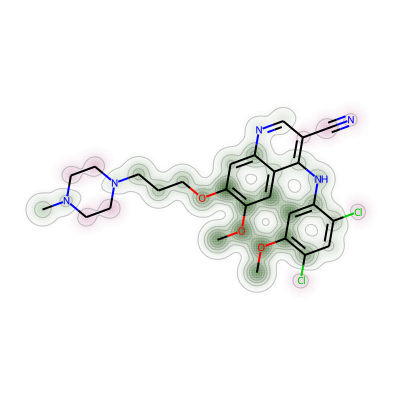

In [ ]:
def show_png(data):
  bio = io.BytesIO(data)
  img = Image.open(bio)
  return img

d = Draw.MolDraw2DCairo(400, 400)
_, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(Osimertinib, Bosutinib, 
                                                                     lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='bv'), 
                                                                     draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())


## 3.2. Morgan count-based Fingerprint

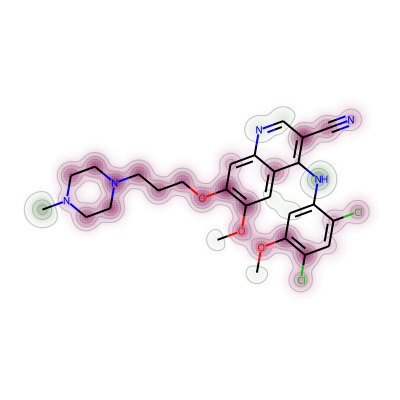

In [ ]:
def show_png(data):
  bio = io.BytesIO(data)
  img = Image.open(bio)
  return img

d = Draw.MolDraw2DCairo(400, 400)
_, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(Osimertinib, Bosutinib, 
                                                                     lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='count'), 
                                                                     draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())


## 3.3. Contributions made by the atoms in Osimertinib to its calculatied logp value

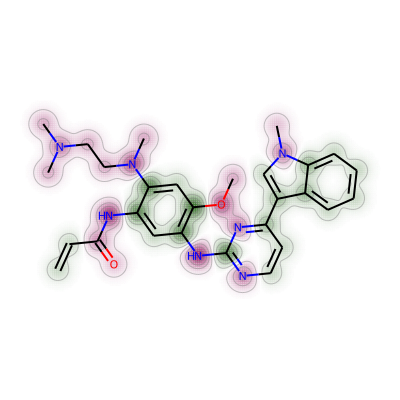

In [ ]:
from rdkit.Chem import rdMolDescriptors
Osi_contribs = rdMolDescriptors._CalcCrippenContribs(Osimertinib)
d = Draw.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(Osimertinib,[x[0] for x in Osi_contribs],draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

## 3.4. Visualizations of various partial charge schemes

### 3.4.1. Gasteiger-Marsilli charges

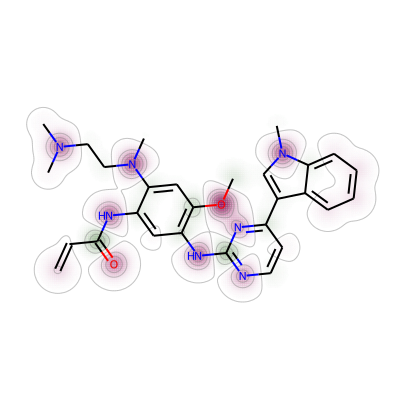

In [ ]:
from rdkit.Chem import rdPartialCharges
rdPartialCharges.ComputeGasteigerCharges(Osimertinib)
chgs = [x.GetDoubleProp("_GasteigerCharge") for x in Osimertinib.GetAtoms()]
d = Draw.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(Osimertinib,chgs,draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

### 3.4.2. Hueckel theory (eHT) using Mulliken analysis

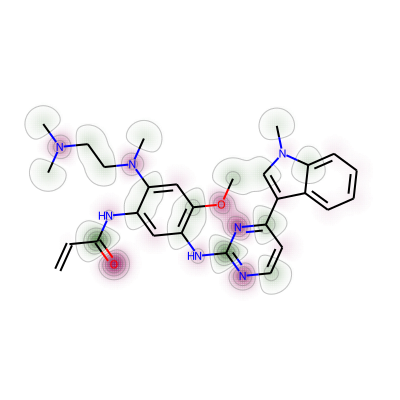

In [ ]:
from rdkit.Chem import rdEHTTools
from rdkit.Chem import rdDistGeom
mh = Chem.AddHs(Osimertinib)
rdDistGeom.EmbedMolecule(mh)
_,res = rdEHTTools.RunMol(mh)
static_chgs = res.GetAtomicCharges()[:Osimertinib.GetNumAtoms()]
d = Draw.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(Osimertinib,list(static_chgs),draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

### 3.4.3. Visualize the variability of the eHT charges with conformation for Osimertinib.

Found 8 conformers


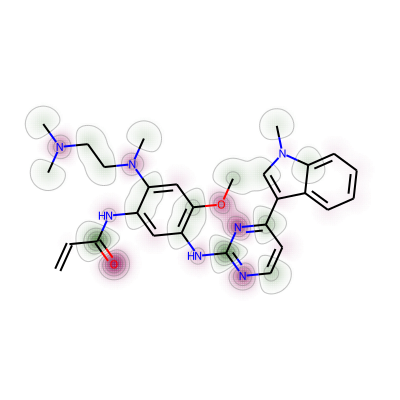

In [ ]:
mh = Chem.AddHs(Osimertinib)
ps = rdDistGeom.ETKDGv2()
ps.pruneRmsThresh = 0.5
ps.randomSeed = 0xf00d
rdDistGeom.EmbedMultipleConfs(mh,10,ps)
print(f'Found {mh.GetNumConformers()} conformers')
chgs = []
for conf in mh.GetConformers():
    _,res = rdEHTTools.RunMol(mh,confId=conf.GetId())
    chgs.append(res.GetAtomicCharges()[:Osimertinib.GetNumAtoms()])
chgs = np.array(chgs)
mean_chgs = np.mean(chgs,axis=0)
std_chgs = np.std(chgs,axis=0)
d = Draw.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(Osimertinib,list(mean_chgs),draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

[0.00282153 0.00518532 0.0097338  0.00595575 0.00678807 0.00586834
 0.00555837 0.00765811 0.00447981 0.00689882 0.00288386 0.02008518
 0.02292674 0.01651292 0.00726957 0.01193159 0.0596909  0.00695315
 0.00947083 0.00941445 0.01148384 0.01181472 0.01161436 0.02366169
 0.00634158 0.01711401 0.00398999 0.00934981 0.02146671 0.00452222
 0.0082888  0.00984815 0.0212393  0.00564414 0.00695668 0.00729511
 0.00496353]
0.05969089675386339 0.0028215330210824693


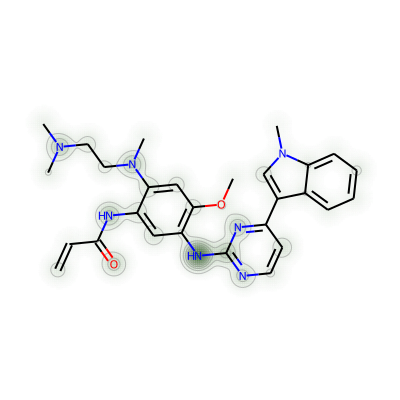

In [ ]:
print(std_chgs)
print(max(std_chgs),min(std_chgs))
d = Draw.MolDraw2DCairo(400, 400)
SimilarityMaps.GetSimilarityMapFromWeights(Osimertinib,list(std_chgs),draw2d=d)
d.FinishDrawing()
show_png(d.GetDrawingText())

In [ ]:
class Similarity_Map:
    def __init__(self, query, base):
        self.query = query
        self.base = base
    
    
    def show_png(self, data):
        bio = io.BytesIO(data)
        img = Image.open(bio)
        return img
    
    def similarity_map_bitvect(self):
        d = Draw.MolDraw2DCairo(400, 400)
        _, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(self.query, self.base, 
                                                                     lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='bv'), 
                                                                     draw2d=d)
        d.FinishDrawing()
        a = self.show_png(d.GetDrawingText())
        a.save("4.png", transparent = True)
        display(self.show_png(d.GetDrawingText()))
        
    def similarity_map_countvect(self):
        d = Draw.MolDraw2DCairo(400, 400)
        _, maxWeight = SimilarityMaps.GetSimilarityMapForFingerprint(self.query, self.base, 
                                                                     lambda m, i: SimilarityMaps.GetMorganFingerprint(m, i, radius=2, fpType='count'), 
                                                                     draw2d=d)
        d.FinishDrawing()
        
        b = self.show_png(d.GetDrawingText())
        b.save("4.1.png", transparent = True)
        display(self.show_png(d.GetDrawingText()))
        
    def plot(self):
        plt.figure(figsize = (16,6))
        plt.subplot(121)
        self.similarity_map_bitvect()
        plt.subplot(122)
        self.similarity_map_countvect()
    

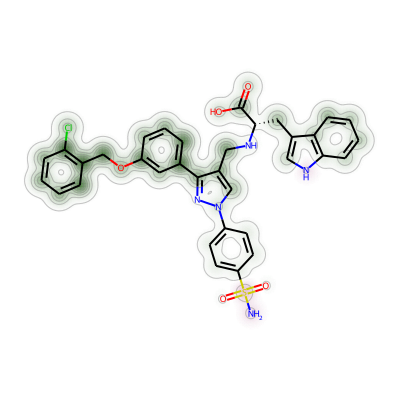

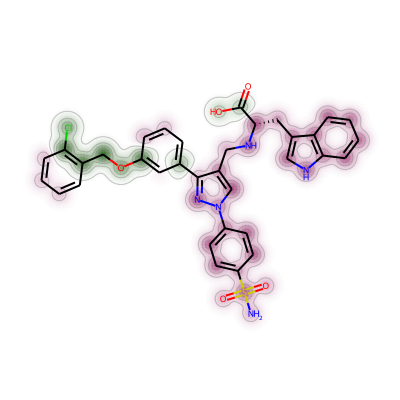

In [ ]:
f = Similarity_Map(atorvastatin, rosuvastatin)
f.similarity_map_bitvect()
f.similarity_map_countvect()

# **4. Enrichment factor**

In [ ]:
class Enrichment_Factor:
    
    def __init__(self,data, similarity_measure, pBio_cutoff, bioactivity, ranked_dataset_percentage_cutoff):
        self.data = data
        self.similarity_measure = similarity_measure
        self.pBio_cutoff = pBio_cutoff
        self.bioactivity = bioactivity
        self.ranked_dataset_percentage_cutoff = ranked_dataset_percentage_cutoff
    
    # 1. Enrichment_data
    def get_enrichment_data(self, similarity_measure):
        """
        Calculates x and y values for enrichment plot:
            x - % ranked dataset
            y - % true actives identified

        Parameters
        ----------
        molecules : pandas.DataFrame
            Molecules with similarity values to a query molecule.
        similarity_measure : str
            Column name which will be used to sort the DataFrame．
        pic50_cutoff : float
            pIC50 cutoff value used to discriminate active and inactive molecules.

        Returns
        -------
        pandas.DataFrame
            Enrichment data: Percentage of ranked dataset by similarity vs. percentage of identified true actives.
        """

        # Get number of molecules in data set
        molecules_all = len(self.data)

        # Get number of active molecules in data set
        actives_all = sum(self.data[self.bioactivity] >= self.pBio_cutoff)

        # Initialize a list that will hold the counter for actives and molecules while iterating through our dataset
        actives_counter_list = []

        # Initialize counter for actives
        actives_counter = 0

        # Note: Data must be ranked for enrichment plots:
        # Sort molecules by selected similarity measure
        self.data.sort_values([similarity_measure], ascending=False, inplace=True)

        # Iterate over the ranked dataset and check each molecule if active (by checking bioactivity)
        for value in self.data[self.bioactivity]:
            if value >= self.pBio_cutoff:
                actives_counter += 1
            actives_counter_list.append(actives_counter)

        # Transform number of molecules into % ranked dataset
        molecules_percentage_list = [i / molecules_all for i in range(1, molecules_all + 1)]

        # Transform number of actives into % true actives identified
        actives_percentage_list = [i / actives_all for i in actives_counter_list]

        # Generate DataFrame with x and y values as well as label
        self.enrichment = pd.DataFrame(
            {
                "% ranked dataset": molecules_percentage_list,
                "% true actives identified": actives_percentage_list,
            }
        )

        return self.enrichment
    # 2. Get EF data
    def EF(self):
        self.enrichment_data = {
            similarity_measure: self.get_enrichment_data(similarity_measure)
            for similarity_measure in self.similarity_measure}
        print("TANIMOTO ECFP")
        display(self.enrichment_data["tanimoto_ecfp"].head())
        print("DICE ECFP")
        display(self.enrichment_data["dice_ecfp"].head())
        print("TVERSKY ECFP")
        display(self.enrichment_data["Tversky_ecfp"].head())
   
    # 3. Calculate enrichment_factor for dataset
    def calculate_enrichment_factor(self, enrichment):
        """
        Get the experimental enrichment factor for a given percentage of the ranked dataset.

        Parameters
        ----------
        enrichment : pd.DataFrame
            Enrichment data: Percentage of ranked dataset by similarity vs. percentage of
            identified true actives.
        ranked_dataset_percentage_cutoff : float or int
            Percentage of ranked dataset to be included in enrichment factor calculation.

        Returns
        -------
        float
            Experimental enrichment factor.
        """

        # Keep only molecules that meet the cutoff
        enrichment = enrichment[
            enrichment["% ranked dataset"] <= self.ranked_dataset_percentage_cutoff / 100
        ]
        # Get highest percentage of actives and the corresponding percentage of actives
        highest_enrichment = enrichment.iloc[-1]
        enrichment_factor = round(100 * float(highest_enrichment["% true actives identified"]), 1)
        return enrichment_factor
    
    # 4. Calculate random enrichment_factor for dataset
    def calculate_enrichment_factor_random(self):
        """
        Get the random enrichment factor for a given percentage of the ranked dataset.

        Parameters
        ----------
        ranked_dataset_percentage_cutoff : float or int
            Percentage of ranked dataset to be included in enrichment factor calculation.

        Returns
        -------
        float
            Random enrichment factor.
        """

        enrichment_factor_random = round(float(self.ranked_dataset_percentage_cutoff), 1)
        return enrichment_factor_random
    
    # 5. Calculate optimal enrichment_factor for dataset
    def calculate_enrichment_factor_optimal(self):
        """
        Get the optimal random enrichment factor for a given percentage of the ranked dataset.

        Parameters
        ----------
        molecules : pandas.DataFrame
            the DataFrame with all the molecules and pIC50.
        ranked_dataset_percentage_cutoff : float or int
            Percentage of ranked dataset to be included in enrichment factor calculation.
        activity_cutoff: float
            pIC50 cutoff value used to discriminate active and inactive molecules

        Returns
        -------
        float
            Optimal enrichment factor.
        """

        ratio = sum(self.data[self.bioactivity] >= pBio_cutoff) / len(self.data) * 100
        if self.ranked_dataset_percentage_cutoff <= ratio:
            enrichment_factor_optimal = round(100 / ratio * self.ranked_dataset_percentage_cutoff, 1)
        else:
            enrichment_factor_optimal = 100.0
        return enrichment_factor_optimal
    
    # 6. Calculate all enrichment_factor for dataset
    def EF_calculate(self):
        for similarity_measure, enrichment in self.enrichment_data.items():
            enrichment_factor = self.calculate_enrichment_factor(enrichment)
            print(
                f"Experimental EF for {self.ranked_dataset_percentage_cutoff}% of ranked dataset ({similarity_measure}): {enrichment_factor}%"
            )
        enrichment_factor_random = self.calculate_enrichment_factor_random()
        print(
            f"Random EF for {self.ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_random}%"
        )
        enrichment_factor_optimal = self.calculate_enrichment_factor_optimal()
        print(
            f"Optimal EF for {self.ranked_dataset_percentage_cutoff}% of ranked dataset: {enrichment_factor_optimal}%"
        )

    # 7. Plot the enrichment data next to the optimal and random enrichment curve!
    def plot_EF(self):
        
        fig, ax = plt.subplots(figsize=(6, 6))

        fontsize = 20

        # Plot enrichment data
        for similarity_measure, enrichment in self.enrichment_data.items():
            ax = enrichment.plot(
                ax=ax,
                x="% ranked dataset",
                y="% true actives identified",
                label=similarity_measure,
                alpha=0.5,
                linewidth=4,
            )
        ax.set_ylabel("% True actives identified", size=fontsize)
        ax.set_xlabel("% Ranked dataset", size=fontsize)

        # Plot optimal curve: Ratio of actives in dataset
        ratio_actives = sum(self.data[self.bioactivity] >= self.pBio_cutoff) / len(self.data)
        ax.plot(
            [0, ratio_actives, 1],
            [0, 1, 1],
            label="Optimal curve",
            color="black",
            linestyle="--",
        )

        # Plot random curve
        ax.plot([0, 1], [0, 1], label="Random curve", color="red", linestyle="--")

        plt.tick_params(labelsize=16)
        plt.legend(
            labels=["MACCS", "Morgan", "RDKF", "Optimal", "Random"],
            loc=(0.5, 0.08),
            fontsize=fontsize,
            labelspacing=0.3,
        )

        # Save plot -- use bbox_inches to include text boxes
        plt.savefig(
            "enrichment_plot.png",
            dpi=300,
            bbox_inches="tight",
            transparent=True,
        )

        plt.show()

In [ ]:
df.head(2)

pIC50  tanimoto_ecfp  dice_ecfp  Tversky_ecfp  active
4142  4.823909           1.00    1.00000       1.00000     0.0
4397  4.346787           0.88    0.93617       0.93617     0.0

TANIMOTO ECFP


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


% ranked dataset  % true actives identified
0          0.000216                   0.000000
1          0.000431                   0.000000
2          0.000647                   0.001104
3          0.000863                   0.002208
4          0.001079                   0.003311

DICE ECFP


% ranked dataset  % true actives identified
0          0.000216                   0.000000
1          0.000431                   0.000000
2          0.000647                   0.001104
3          0.000863                   0.002208
4          0.001079                   0.003311

TVERSKY ECFP


% ranked dataset  % true actives identified
0          0.000216                   0.000000
1          0.000431                   0.000000
2          0.000647                   0.001104
3          0.000863                   0.002208
4          0.001079                   0.003311

Experimental EF for 1% of ranked dataset (tanimoto_ecfp): 2.3%
Experimental EF for 1% of ranked dataset (dice_ecfp): 2.3%
Experimental EF for 1% of ranked dataset (Tversky_ecfp): 2.3%
Random EF for 1% of ranked dataset: 1.0%
Optimal EF for 1% of ranked dataset: 5.1%


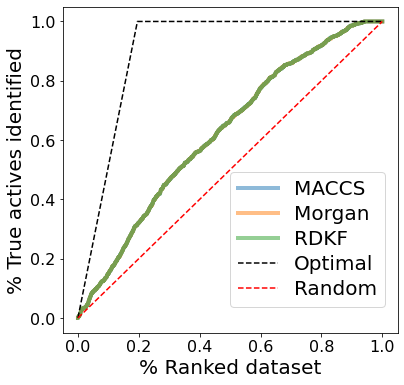

In [ ]:
pBio_cutoff = 8
similarity_measures = ["tanimoto_ecfp", "dice_ecfp", "Tversky_ecfp"]
ef = Enrichment_Factor(data = df, similarity_measure=similarity_measures, pBio_cutoff=pBio_cutoff, 
                       bioactivity = 'pIC50', ranked_dataset_percentage_cutoff = 1
                      )
ef.EF()
ef.EF_calculate()
ef.plot_EF()

# **5. ROC AUC**

In [ ]:
s.data.to_csv("data_roc.csv")

Plotting ROC AUC curve of model Similarity :
1.0 1.0 0.0 0.0
1.0 1.0 0.005 0.0
1.0 1.0 0.01 0.0
1.0 1.0 0.015 0.0
1.0 1.0 0.02 0.0
1.0 1.0 0.025 0.0
1.0 1.0 0.03 0.0
1.0 1.0 0.035 0.0
1.0 1.0 0.04 0.0
1.0 1.0 0.045 0.0
1.0 1.0 0.05 0.0
1.0 1.0 0.055 0.0
1.0 1.0 0.06 0.0
1.0 1.0 0.065 0.0
1.0 1.0 0.07 0.0
1.0 1.0 0.075 0.0
1.0 1.0 0.08 0.0
1.0 1.0 0.085 0.0
1.0 1.0 0.09 0.0
1.0 1.0 0.095 0.0
1.0 1.0 0.1 0.0
1.0 1.0 0.105 0.0
1.0 1.0 0.11 0.0
1.0 1.0 0.115 0.0
1.0 0.9951076320939335 0.12 0.0699454637990664
1.0 0.9902152641878669 0.125 0.09891782353111661
1.0 0.9853228962818004 0.13 0.12114909705895309
1.0 0.9608610567514677 0.135 0.19783564706223267
1.0 0.9363992172211351 0.14 0.2521919562136448
1.0 0.9119373776908023 0.145 0.2967534705933491
1.0 0.863013698630137 0.15 0.3701166050988026
1.0 0.7847358121330724 0.155 0.46396571841778095
1.0 0.7040117416829745 0.16 0.5440480294211398
1.0 0.5865949119373777 0.165 0.6429658529522562
1.0 0.4569471624266145 0.17 0.7369211881696615
0.9995107632

1.0 1.0 0.245 0.0
1.0 1.0 0.25 0.0
1.0 1.0 0.255 0.0
1.0 1.0 0.26 0.0
1.0 1.0 0.265 0.0
1.0 1.0 0.27 0.0
1.0 1.0 0.275 0.0
1.0 1.0 0.28 0.0
1.0 1.0 0.285 0.0
1.0 1.0 0.29 0.0
1.0 1.0 0.295 0.0
1.0 1.0 0.3 0.0
1.0 1.0 0.305 0.0
1.0 1.0 0.31 0.0
0.9995107632093934 1.0 0.315 0.0
0.9990215264187867 1.0 0.32 0.0
0.9980430528375733 1.0 0.325 0.0
0.99706457925636 1.0 0.33 0.0
0.9965753424657534 1.0 0.335 0.0
0.9960861056751468 1.0 0.34 0.0
0.9931506849315068 1.0 0.345 0.0
0.9911937377690803 1.0 0.35 0.0
0.9882583170254403 1.0 0.355 0.0
0.9848336594911937 1.0 0.36 0.0
0.9770058708414873 1.0 0.365 0.0
0.9672211350293543 1.0 0.37 0.0
0.9584148727984344 1.0 0.375 0.0
0.9432485322896281 1.0 0.38 0.0
0.9266144814090019 1.0 0.385 0.0
0.8977495107632094 1.0 0.39 0.0
0.8669275929549902 1.0 0.395 0.0
0.8272994129158513 1.0 0.4 0.0
0.7891389432485323 1.0 0.405 0.0
0.7490215264187867 1.0 0.41 0.0
0.724559686888454 1.0 0.415 0.0
0.7015655577299413 0.9975538160469667 0.42 0.04142654232879986
0.673679060665

0.9955968688845401 0.7773972602739726 0.42 0.47076808587281394
0.9955968688845401 0.7583170254403131 0.425 0.49052911507302627
0.9951076320939335 0.7485322896281801 0.43 0.5002373814662243
0.9931506849315068 0.7411937377690803 0.435 0.5069848287663065
0.9931506849315068 0.7411937377690803 0.44 0.5069848287663065
0.9907045009784736 0.7240704500978473 0.445 0.522842851190515
0.9892367906066536 0.7167318982387475 0.45 0.5293573725448059
0.987279843444227 0.702054794520548 0.455 0.5423608538793259
0.985812133072407 0.6898238747553816 0.46 0.5529696082566666
0.9853228962818004 0.675146771037182 0.465 0.5657608367748148
0.9833659491193738 0.6457925636007827 0.47 0.590182625870888
0.9809197651663405 0.6237769080234834 0.475 0.6074904666180031
0.9794520547945206 0.601761252446184 0.48 0.6245444416455738
0.976027397260274 0.5895303326810176 0.485 0.6329531112551995
0.974559686888454 0.5797455968688845 0.49 0.6399710927291592
0.9726027397260274 0.5454990215264188 0.495 0.6648675784481939
0.97260

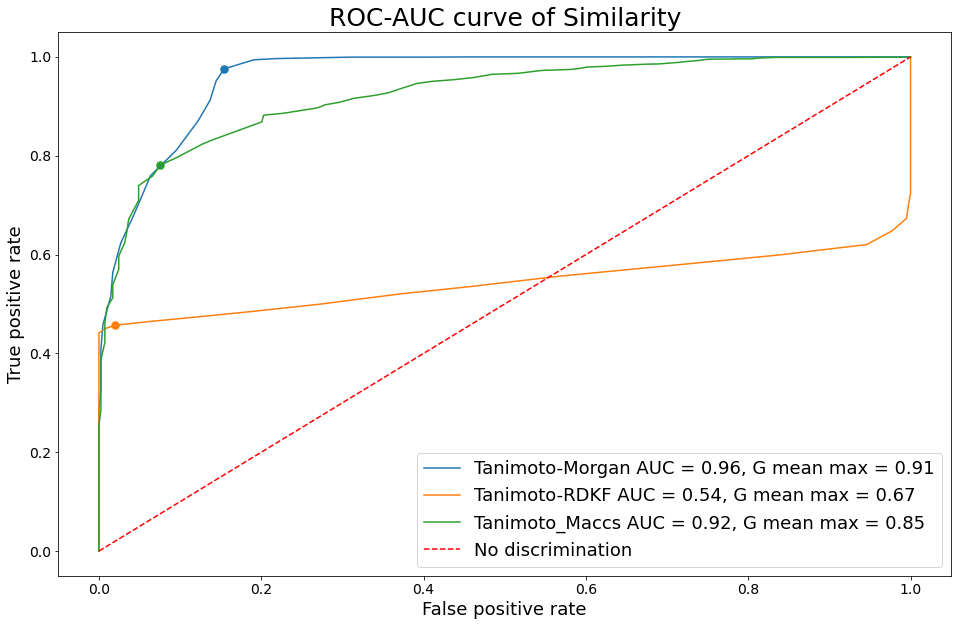

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd 
import numpy as trapz
import os
import glob

class ROC_AUC_class:
  
  def __init__(self, data_0):
    self.data_0 = data_0.copy()
    self.data = self.data_0.copy()
  def ROC_AUC(self):
    self.name_plot = i[len(csv_dir_1)+1:-4]
    self.roc_point=[]
    row = len(self.data)
    self.thresholds = np.array(list(range(0, 1005, 5)))/1000
    self.roc_point = []
    self.gmeanmax = 0
    self.thresholdmax = 0
    for self.threshold in self.thresholds:
      self.tp = 0; self.fp = 0; self.fn = 0; self.tn = 0

      for self.index, self.instance in self.data.iterrows():
        self.pre = self.instance["Prediction"]
        self.act = self.instance["Activity"]  

        if self.pre >= self.threshold:
          self.pre_class = 1
        else:
          self.pre_class = 0
      
        if self.pre_class == 1 and self.act == 1:
          self.tp = self.tp + 1
        elif self.pre_class == 0 and self.act == 1:
          self.fn = self.fn + 1
        elif self.pre_class == 1 and self.act == 0:
          self.fp = self.fp + 1
        elif self.pre_class == 0 and self.act == 0:
          self.tn = self.tn + 1
      self.tpr = self.tp / (self.tp+self.fn)
      self.fpr = self.fp / (self.tn+self.fp)
      self.roc_point.append([self.tpr, self.fpr])
      self.gmean = np.sqrt(self.tpr*(1-self.fpr))
      if self.gmeanmax <= self.gmean:
        self.gmeanmax = self.gmean
        self.thresholdmax = self.threshold
        self.tprmax = self.tpr
        self.fprmax = self.fpr
      print(self.tpr, self.fpr, self.threshold, self.gmean)

    self.pivot = pd.DataFrame(self.roc_point, columns = ["x", "y"])
    self.pivot["threshold"] = self.thresholds
    self.AUC_score = abs(np.trapz(self.pivot.x, self.pivot.y))
    print(f"AUC of {self.name_plot} is {self.AUC_score}")
    print(f"Gmean max of {self.name_plot} is {self.gmeanmax} at threshold {self.thresholdmax}")
    print("----------------------------------------------------------------------")
    plt.plot(self.pivot.y, self.pivot.x, label=self.name_plot+" AUC = "+str(round(self.AUC_score,2))+", G mean max = "+str(round(self.gmeanmax,2)))
    plt.xlabel('False positive rate', fontsize=18)
    plt.ylabel('True positive rate', fontsize=18)
    plt.legend()
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(fontsize = 18)
    plt.scatter(self.fprmax, self.tprmax, linewidths=2.5)
    plot_title = "ROC-AUC curve of "+k
    #plot_title = "ROC-AUC curve of model "+k
    plt.title(plot_title, fontsize = 25)

folder_list = os.listdir("/Users/macbook/Desktop/Bao_Dy/Similarity/BMS-1166/ROC")
for k in folder_list:
    if k == "Similarity":
        plt.figure(figsize = (16,10))
        csv_dir = "/Users/macbook/Desktop/Bao_Dy/Similarity/BMS-1166/ROC/"+k
        os.chdir(csv_dir)
        csv_dir_1 = str(os.getcwd())
        csv_dir_2 = csv_dir_1+"/*.csv"
        print('Plotting ROC AUC curve of model',k,':')
        csv_name =[]
        for i in sorted(glob.glob(csv_dir_2)):
            csv_name.append(i[len(csv_dir_1)+1:-4])
            data = pd.read_csv(i[len(csv_dir_1)+1:])
            data = pd.read_csv(i[len(csv_dir_1)+1:])
            df = ROC_AUC_class(data)
            df.ROC_AUC()
        plt.plot([0, 1], color='red', linestyle='dashed', label='No discrimination') 
        plt.legend(loc = 'lower right', fontsize = 18)
        plt.savefig("ROC.png", dpi = 600, transparent = True)
        plt.show()

Plotting ROC AUC curve of model Similarity :
1.0 1.0 0.0
1.0 1.0 0.005
1.0 1.0 0.01
1.0 1.0 0.015
1.0 1.0 0.02
1.0 1.0 0.025
1.0 1.0 0.03
1.0 1.0 0.035
1.0 1.0 0.04
1.0 1.0 0.045
1.0 1.0 0.05
1.0 1.0 0.055
1.0 1.0 0.06
1.0 1.0 0.065
1.0 1.0 0.07
1.0 1.0 0.075
1.0 1.0 0.08
1.0 1.0 0.085
1.0 1.0 0.09
1.0 1.0 0.095
1.0 1.0 0.1
1.0 1.0 0.105
1.0 1.0 0.11
1.0 1.0 0.115
1.0 0.9951076320939335 0.12
1.0 0.9902152641878669 0.125
1.0 0.9853228962818004 0.13
1.0 0.9608610567514677 0.135
1.0 0.9363992172211351 0.14
1.0 0.9119373776908023 0.145
1.0 0.863013698630137 0.15
1.0 0.7847358121330724 0.155
1.0 0.7040117416829745 0.16
1.0 0.5865949119373777 0.165
1.0 0.4569471624266145 0.17
0.9995107632093934 0.3987279843444227 0.175
0.9995107632093934 0.3082191780821918 0.18
0.9975538160469667 0.24706457925636008 0.185
0.9965753424657534 0.21771037181996086 0.19
0.9941291585127201 0.1908023483365949 0.195
0.9867906066536204 0.1761252446183953 0.2
0.9755381604696673 0.1541095890410959 0.205
0.9510763209393

0.004403131115459882 0.0 0.715
0.003913894324853229 0.0 0.72
0.003913894324853229 0.0 0.725
0.003913894324853229 0.0 0.73
0.003424657534246575 0.0 0.735
0.0019569471624266144 0.0 0.74
0.0019569471624266144 0.0 0.745
0.0019569471624266144 0.0 0.75
0.0019569471624266144 0.0 0.755
0.0019569471624266144 0.0 0.76
0.0019569471624266144 0.0 0.765
0.0014677103718199608 0.0 0.77
0.0014677103718199608 0.0 0.775
0.0014677103718199608 0.0 0.78
0.0009784735812133072 0.0 0.785
0.0009784735812133072 0.0 0.79
0.0009784735812133072 0.0 0.795
0.0009784735812133072 0.0 0.8
0.0009784735812133072 0.0 0.805
0.0009784735812133072 0.0 0.81
0.0009784735812133072 0.0 0.815
0.0009784735812133072 0.0 0.82
0.0009784735812133072 0.0 0.825
0.0009784735812133072 0.0 0.83
0.0009784735812133072 0.0 0.835
0.0009784735812133072 0.0 0.84
0.0009784735812133072 0.0 0.845
0.0004892367906066536 0.0 0.85
0.0004892367906066536 0.0 0.855
0.0 0.0 0.86
0.0 0.0 0.865
0.0 0.0 0.87
0.0 0.0 0.875
0.0 0.0 0.88
0.0 0.0 0.885
0.0 0.0 0.8

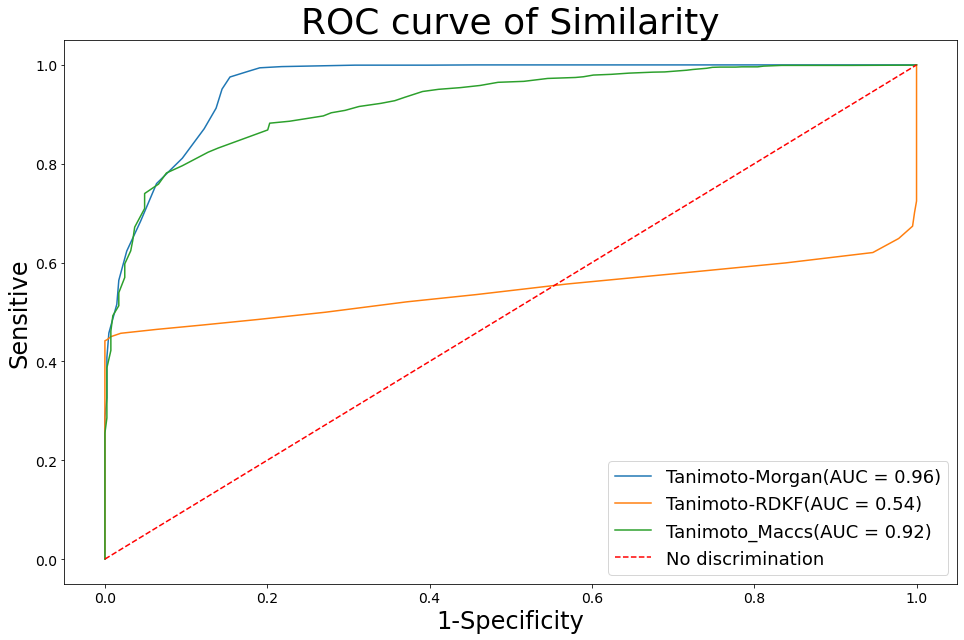

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import numpy as trapz
import os
#from google.colab import drive
import glob

class ROC_AUC_class:
  
  def __init__(self, data_0):
    self.data_0 = data_0.copy()
    self.data = self.data_0.copy()
  def ROC_AUC(self):
    self.name_plot = i[len(csv_dir_1)+1:-4]
    self.roc_point=[]
    row = len(self.data)
    self.thresholds = np.array(list(range(0, 1005, 5)))/1000
    self.roc_point = []
    for self.threshold in self.thresholds:
      self.tp = 0; self.fp = 0; self.fn = 0; self.tn = 0

      for self.index, self.instance in self.data.iterrows():
        self.pre = self.instance["Prediction"]
        self.act = self.instance["Activity"]  

        if self.pre >= self.threshold:
          self.pre_class = 1
        else:
          self.pre_class = 0
      
        if self.pre_class == 1 and self.act == 1:
          self.tp = self.tp + 1
        elif self.pre_class == 0 and self.act == 1:
          self.fn = self.fn + 1
        elif self.pre_class == 1 and self.act == 0:
          self.fp = self.fp + 1
        elif self.pre_class == 0 and self.act == 0:
          self.tn = self.tn + 1
      
      self.tpr = self.tp / (self.tp+self.fn)
      self.fpr = self.fp / (self.tn+self.fp)
      self.roc_point.append([self.tpr, self.fpr])
      print(self.tpr, self.fpr, self.threshold)

    self.pivot = pd.DataFrame(self.roc_point, columns = ["x", "y"])
    self.pivot["threshold"] = self.thresholds
    self.AUC_score = abs(np.trapz(self.pivot.x, self.pivot.y))
    print(f"AUC of {self.name_plot} is {self.AUC_score}")
    plt.plot(self.pivot.y, self.pivot.x, label=self.name_plot+"(AUC = "+str(round(self.AUC_score,2))+")")
    plt.xlabel('1-Specificity', fontsize=24)
    plt.ylabel('Sensitive', fontsize=24)
    plt.legend()
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(fontsize = 18)
    plot_title = "ROC curve of "+k
    plt.title(plot_title, fontsize = 36)

folder_list = os.listdir("/Users/macbook/Desktop/Bao_Dy/Similarity/BMS-1166/ROC")
for k in folder_list:
    if k == "Similarity":
        plt.figure(figsize = (16,10))
        csv_dir = "/Users/macbook/Desktop/Bao_Dy/Similarity/BMS-1166/ROC/"+k
        os.chdir(csv_dir)
        csv_dir_1 = str(os.getcwd())
        csv_dir_2 = csv_dir_1+"/*.csv"
        print('Plotting ROC AUC curve of model',k,':')
        csv_name =[]
        for i in sorted(glob.glob(csv_dir_2)):
            csv_name.append(i[len(csv_dir_1)+1:-4])
            data = pd.read_csv(i[len(csv_dir_1)+1:])
            data = pd.read_csv(i[len(csv_dir_1)+1:])
            df = ROC_AUC_class(data)
            df.ROC_AUC()
        plt.plot([0, 1], color='red', linestyle='dashed', label='No discrimination') 
        plt.legend(loc = 'lower right', fontsize = 18)
        plt.savefig("ROC.png", dpi = 600, transparent = True)
        plt.show()

In [ ]:
os.chdir("/Users/macbook/Desktop/Bao_Dy/Similarity/BMS-1166")



Plotting Precision-Recall curve of model Similarity :
0.09090909090909091 1.0 0.0 0.16666666666666669
0.09090909090909091 1.0 0.005 0.16666666666666669
0.09090909090909091 1.0 0.01 0.16666666666666669
0.09090909090909091 1.0 0.015 0.16666666666666669
0.09090909090909091 1.0 0.02 0.16666666666666669
0.09090909090909091 1.0 0.025 0.16666666666666669
0.09090909090909091 1.0 0.03 0.16666666666666669
0.09090909090909091 1.0 0.035 0.16666666666666669
0.09090909090909091 1.0 0.04 0.16666666666666669
0.09090909090909091 1.0 0.045 0.16666666666666669
0.09090909090909091 1.0 0.05 0.16666666666666669
0.09090909090909091 1.0 0.055 0.16666666666666669
0.09090909090909091 1.0 0.06 0.16666666666666669
0.09090909090909091 1.0 0.065 0.16666666666666669
0.09090909090909091 1.0 0.07 0.16666666666666669
0.09090909090909091 1.0 0.075 0.16666666666666669
0.09090909090909091 1.0 0.08 0.16666666666666669
0.09090909090909091 1.0 0.085 0.16666666666666669
0.09090909090909091 1.0 0.09 0.16666666666666669
0.09090

0.09090909090909091 1.0 0.02 0.16666666666666669
0.09090909090909091 1.0 0.025 0.16666666666666669
0.09090909090909091 1.0 0.03 0.16666666666666669
0.09090909090909091 1.0 0.035 0.16666666666666669
0.09090909090909091 1.0 0.04 0.16666666666666669
0.09090909090909091 1.0 0.045 0.16666666666666669
0.09090909090909091 1.0 0.05 0.16666666666666669
0.09090909090909091 1.0 0.055 0.16666666666666669
0.09090909090909091 1.0 0.06 0.16666666666666669
0.09090909090909091 1.0 0.065 0.16666666666666669
0.09090909090909091 1.0 0.07 0.16666666666666669
0.09090909090909091 1.0 0.075 0.16666666666666669
0.09090909090909091 1.0 0.08 0.16666666666666669
0.09090909090909091 1.0 0.085 0.16666666666666669
0.09090909090909091 1.0 0.09 0.16666666666666669
0.09090909090909091 1.0 0.095 0.16666666666666669
0.09090909090909091 1.0 0.1 0.16666666666666669
0.09090909090909091 1.0 0.105 0.16666666666666669
0.09090909090909091 1.0 0.11 0.16666666666666669
0.09090909090909091 1.0 0.115 0.16666666666666669
0.090909090

1.0 0.0009784735812133072 0.8 0.0019550342130987292
1.0 0.0009784735812133072 0.805 0.0019550342130987292
1.0 0.0009784735812133072 0.81 0.0019550342130987292
1.0 0.0009784735812133072 0.815 0.0019550342130987292
1.0 0.0009784735812133072 0.82 0.0019550342130987292
1.0 0.0009784735812133072 0.825 0.0019550342130987292
1.0 0.0009784735812133072 0.83 0.0019550342130987292
1.0 0.0009784735812133072 0.835 0.0019550342130987292
1.0 0.0009784735812133072 0.84 0.0019550342130987292
1.0 0.0009784735812133072 0.845 0.0019550342130987292
1.0 0.0004892367906066536 0.85 0.0009779951100244498
1.0 0.0004892367906066536 0.855 0.0009779951100244498
1 0.0 0.86 0.0
1 0.0 0.865 0.0
1 0.0 0.87 0.0
1 0.0 0.875 0.0
1 0.0 0.88 0.0
1 0.0 0.885 0.0
1 0.0 0.89 0.0
1 0.0 0.895 0.0
1 0.0 0.9 0.0
1 0.0 0.905 0.0
1 0.0 0.91 0.0
1 0.0 0.915 0.0
1 0.0 0.92 0.0
1 0.0 0.925 0.0
1 0.0 0.93 0.0
1 0.0 0.935 0.0
1 0.0 0.94 0.0
1 0.0 0.945 0.0
1 0.0 0.95 0.0
1 0.0 0.955 0.0
1 0.0 0.96 0.0
1 0.0 0.965 0.0
1 0.0 0.97 0.0
1 0.

0.5918367346938775 0.7093933463796478 0.625 0.6453048509123275
0.6467263306641545 0.6717221135029354 0.63 0.6589872810175187
0.652949925632127 0.6443248532289628 0.635 0.6486087170647624
0.6623376623376623 0.6237769080234834 0.64 0.6424792139077853
0.7094712376525276 0.5973581213307241 0.645 0.6486055776892431
0.6996996996996997 0.5699608610567515 0.65 0.6282016716095983
0.7589531680440771 0.5391389432485323 0.655 0.6304347826086957
0.7496423462088698 0.512720156555773 0.66 0.6089482858803021
0.8342999171499585 0.4926614481409002 0.665 0.6195016917871424
0.8627630375114365 0.46135029354207435 0.67 0.6012113484220593
0.8519249753208292 0.42221135029354206 0.675 0.5646058227019953
0.9405469678953626 0.386986301369863 0.68 0.5483535528596187
0.9362244897959183 0.35909980430528377 0.685 0.5190947666195191
0.9314128943758574 0.3321917808219178 0.69 0.48972232239451857
0.9266862170087976 0.30919765166340507 0.695 0.46368305209097577
0.9211356466876972 0.2857142857142857 0.7 0.436146377893950

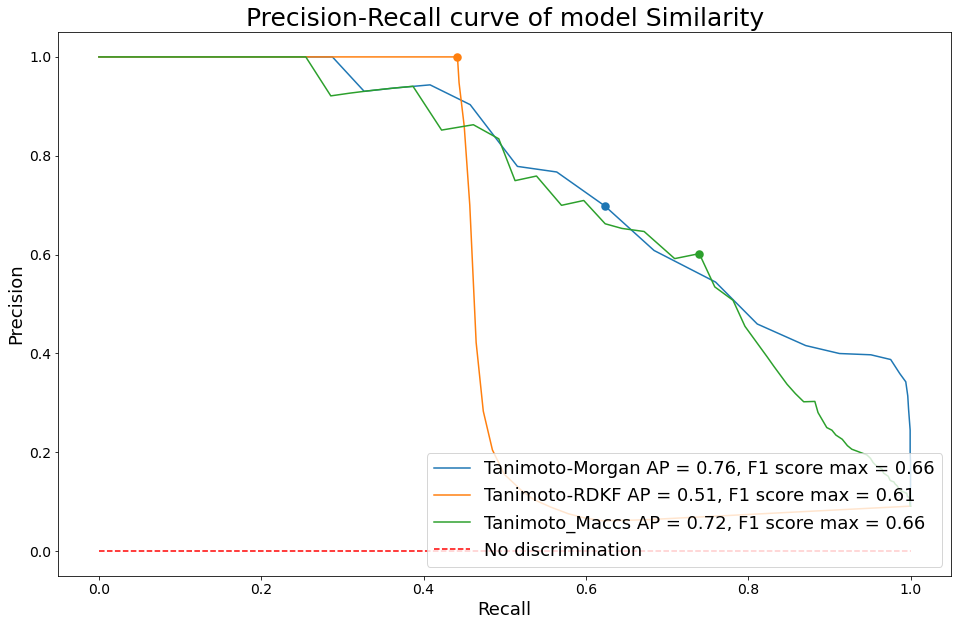

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd 
import numpy as trapz
import os
import glob

class Precision_recall_class:
  
  def __init__(self, data_0):
    self.data_0 = data_0.copy()
    self.data = self.data_0.copy()
  def Precision_recall_curve(self):
    self.name_plot = i[len(csv_dir_1)+1:-4]
    row = len(self.data)
    self.thresholds = np.array(list(range(0, 1005, 5)))/1000
    self.precision_recall_point = []
    self.f1_scoremax = 0
    for self.threshold in self.thresholds:
      self.tp = 0; self.fp = 0; self.fn = 0; self.tn = 0

      for self.index, self.instance in self.data.iterrows():
        self.pre = self.instance["Prediction"]
        self.act = self.instance["Activity"]  

        if self.pre >= self.threshold:
          self.pre_class = 1
        else:
          self.pre_class = 0
      
        if self.pre_class == 1 and self.act == 1:
          self.tp = self.tp + 1
        elif self.pre_class == 0 and self.act == 1:
          self.fn = self.fn + 1
        elif self.pre_class == 1 and self.act == 0:
          self.fp = self.fp + 1
        elif self.pre_class == 0 and self.act == 0:
          self.tn = self.tn + 1
      if self.tp+self.fp != 0:
        self.precision = self.tp / (self.tp+self.fp)
      else:
        self.precision = 1
      if self.tp+self.fn != 0:
        self.recall = self.tp / (self.tp+self.fn)
      else: 
        self.recall = 0
      if self.precision+self.recall != 0:
        self.f1_score = (2*self.precision*self.recall)/(self.precision+self.recall)
      else:
        self.f1_score = 0
      if self.f1_scoremax <= self.f1_score:
        self.f1_scoremax = self.f1_score
        self.thresholdmax = self.threshold
        self.precisionmax = self.precision
        self.recallmax = self.recall
      self.precision_recall_point.append([self.precision, self.recall])
      print(self.precision, self.recall, self.threshold, self.f1_score)

    self.pivot = pd.DataFrame(self.precision_recall_point, columns = ["x", "y"])
    self.pivot["threshold"] = self.thresholds
    self.AUC_score = abs(np.trapz(self.pivot.x, self.pivot.y))
    print(f"AUC of {self.name_plot} is {self.AUC_score}")
    print(f"F1 score max of {self.name_plot} is {self.f1_scoremax} at threshold {self.thresholdmax}")
    print("----------------------------------------------------------------------")
    plt.plot(self.pivot.y, self.pivot.x, label=self.name_plot+" AP = "+str(round(self.AUC_score,2))+", F1 score max = "+str(round(self.f1_scoremax,2)))
    plt.xlabel('Recall', fontsize=18)
    plt.ylabel('Precision', fontsize=18)
    plt.legend()
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(fontsize = 18)
    plt.scatter(self.recallmax, self.precisionmax, linewidths=2.5)
    plot_title = "Precision-Recall curve of model "+k
    plt.title(plot_title, fontsize = 25)

folder_list = os.listdir('/Users/macbook/Desktop/Bao_Dy/Similarity/BMS-1166/ROC')
for k in folder_list:
    if k == "Similarity":
        plt.figure(figsize = (16,10))
        csv_dir = "/Users/macbook/Desktop/Bao_Dy/Similarity/BMS-1166/ROC/"+k
        os.chdir(csv_dir)
        csv_dir_1 = str(os.getcwd())
        csv_dir_2 = csv_dir_1+"/*.csv"
        print('Plotting Precision-Recall curve of model',k,':')
        csv_name =[]
        for i in sorted(glob.glob(csv_dir_2)):
            csv_name.append(i[len(csv_dir_1)+1:-4])
            data = pd.read_csv(i[len(csv_dir_1)+1:])
            data = pd.read_csv(i[len(csv_dir_1)+1:])
            df = Precision_recall_class(data)
            df.Precision_recall_curve()
        plt.plot([0, 0], color='red', linestyle='dashed', label='No discrimination') 
        plt.legend(loc = 'lower right', fontsize = 18)
        plt.savefig("PR.png", dpi = 600, transparent = True)
        plt.show()

Plotting Precision-Recall curve of model Similarity :
0.09090909090909091 1.0 0.0
0.09090909090909091 1.0 0.004975124378109453
0.09090909090909091 1.0 0.009950248756218905
0.09090909090909091 1.0 0.014925373134328358
0.09090909090909091 1.0 0.01990049751243781
0.09090909090909091 1.0 0.024875621890547265
0.09090909090909091 1.0 0.029850746268656716
0.09090909090909091 1.0 0.03482587064676617
0.09090909090909091 1.0 0.03980099502487562
0.09090909090909091 1.0 0.04477611940298507
0.09090909090909091 1.0 0.04975124378109453
0.09090909090909091 1.0 0.05472636815920398
0.09090909090909091 1.0 0.05970149253731343
0.09090909090909091 1.0 0.06467661691542288
0.09090909090909091 1.0 0.06965174129353234
0.09090909090909091 1.0 0.07462686567164178
0.09090909090909091 1.0 0.07960199004975124
0.09090909090909091 1.0 0.0845771144278607
0.09090909090909091 1.0 0.08955223880597014
0.09090909090909091 1.0 0.0945273631840796
0.09090909090909091 1.0 0.09950248756218906
0.09090909090909091 1.0 0.104477611

0.09090909090909091 1.0 0.04975124378109453
0.09090909090909091 1.0 0.05472636815920398
0.09090909090909091 1.0 0.05970149253731343
0.09090909090909091 1.0 0.06467661691542288
0.09090909090909091 1.0 0.06965174129353234
0.09090909090909091 1.0 0.07462686567164178
0.09090909090909091 1.0 0.07960199004975124
0.09090909090909091 1.0 0.0845771144278607
0.09090909090909091 1.0 0.08955223880597014
0.09090909090909091 1.0 0.0945273631840796
0.09090909090909091 1.0 0.09950248756218906
0.09090909090909091 1.0 0.1044776119402985
0.09090909090909091 1.0 0.10945273631840796
0.09090909090909091 1.0 0.11442786069651742
0.09090909090909091 1.0 0.11940298507462686
0.09090909090909091 1.0 0.12437810945273632
0.09090909090909091 1.0 0.12935323383084577
0.09090909090909091 1.0 0.13432835820895522
0.09090909090909091 1.0 0.13930348258706468
0.09090909090909091 1.0 0.14427860696517414
0.09090909090909091 1.0 0.14925373134328357
0.09090909090909091 1.0 0.15422885572139303
0.09090909090909091 1.0 0.159203980

0 0.0 0.9701492537313433
0 0.0 0.9751243781094527
0 0.0 0.9800995024875622
0 0.0 0.9850746268656716
0 0.0 0.9900497512437811
AUC of Tanimoto-RDKF is 0.5074222397646003
0.09090909090909091 1.0 0.0
0.09090909090909091 1.0 0.004975124378109453
0.09090909090909091 1.0 0.009950248756218905
0.09090909090909091 1.0 0.014925373134328358
0.09090909090909091 1.0 0.01990049751243781
0.09090909090909091 1.0 0.024875621890547265
0.09090909090909091 1.0 0.029850746268656716
0.09090909090909091 1.0 0.03482587064676617
0.09090909090909091 1.0 0.03980099502487562
0.09090909090909091 1.0 0.04477611940298507
0.09090909090909091 1.0 0.04975124378109453
0.09090909090909091 1.0 0.05472636815920398
0.09090909090909091 1.0 0.05970149253731343
0.09090909090909091 1.0 0.06467661691542288
0.09090909090909091 1.0 0.06965174129353234
0.09090909090909091 1.0 0.07462686567164178
0.09090909090909091 1.0 0.07960199004975124
0.09090909090909091 1.0 0.0845771144278607
0.09090909090909091 1.0 0.08955223880597014
0.090909

1.0 0.011252446183953033 0.8109452736318408
1.0 0.010273972602739725 0.8159203980099502
1.0 0.008806262230919765 0.8208955223880597
1.0 0.007827788649706457 0.8258706467661692
1.0 0.007827788649706457 0.8308457711442786
1.0 0.0053816046966731895 0.835820895522388
1.0 0.0053816046966731895 0.8407960199004975
1.0 0.004403131115459882 0.845771144278607
1.0 0.003913894324853229 0.8507462686567164
1.0 0.003424657534246575 0.8557213930348259
1.0 0.0019569471624266144 0.8606965174129353
1.0 0.0014677103718199608 0.8656716417910447
1.0 0.0014677103718199608 0.8706467661691543
1.0 0.0004892367906066536 0.8756218905472637
1.0 0.0004892367906066536 0.8805970149253731
1.0 0.0004892367906066536 0.8855721393034826
1.0 0.0004892367906066536 0.8905472636815921
1.0 0.0004892367906066536 0.8955223880597015
1.0 0.0004892367906066536 0.900497512437811
1.0 0.0004892367906066536 0.9054726368159204
1.0 0.0004892367906066536 0.9104477611940298
0 0.0 0.9154228855721394
0 0.0 0.9203980099502488
0 0.0 0.92537313

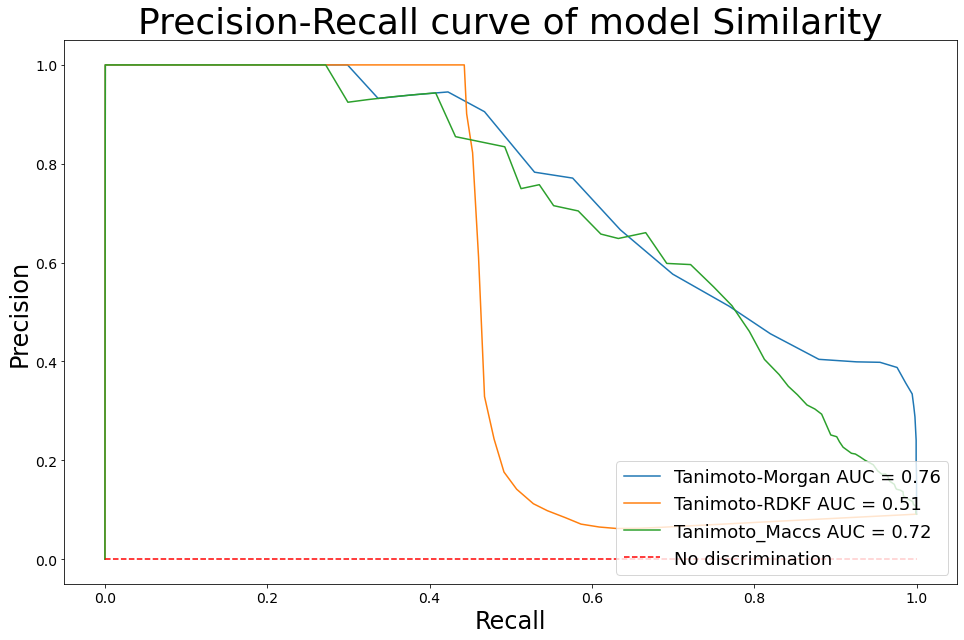

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd 
import numpy as trapz
import os
import glob

class Precision_recall_class:
  
  def __init__(self, data_0):
    self.data_0 = data_0.copy()
    self.data = self.data_0.copy()
  def Precision_recall_curve(self):
    self.name_plot = i[len(csv_dir_1)+1:-4]
    row = len(self.data)
    self.thresholds = np.array(list(range(0, 1000, 5)))/1005
    self.precision_recall_point = []
    for self.threshold in self.thresholds:
      self.tp = 0; self.fp = 0; self.fn = 0; self.tn = 0

      for self.index, self.instance in self.data.iterrows():
        self.pre = self.instance["Prediction"]
        self.act = self.instance["Activity"]  

        if self.pre >= self.threshold:
          self.pre_class = 1
        else:
          self.pre_class = 0
      
        if self.pre_class == 1 and self.act == 1:
          self.tp = self.tp + 1
        elif self.pre_class == 0 and self.act == 1:
          self.fn = self.fn + 1
        elif self.pre_class == 1 and self.act == 0:
          self.fp = self.fp + 1
        elif self.pre_class == 0 and self.act == 0:
          self.tn = self.tn + 1
      if self.tp+self.fp != 0:
        self.precision = self.tp / (self.tp+self.fp)
      else:
        self.precision = 0
      if self.tp+self.fn != 0:
        self.recall = self.tp / (self.tp+self.fn)
      else: 
        self.recall = 0
      self.precision_recall_point.append([self.precision, self.recall])
      print(self.precision, self.recall, self.threshold)

    self.pivot = pd.DataFrame(self.precision_recall_point, columns = ["x", "y"])
    self.pivot["threshold"] = self.thresholds
    self.AUC_score = abs(np.trapz(self.pivot.x, self.pivot.y))
    print(f"AUC of {self.name_plot} is {self.AUC_score}")
    plt.plot(self.pivot.y, self.pivot.x, label=self.name_plot+" AUC = "+str(round(self.AUC_score,2)))
    plt.xlabel('Recall', fontsize=24)
    plt.ylabel('Precision', fontsize=24)
    plt.legend()
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(fontsize = 18)
    plot_title = "Precision-Recall curve of model "+k
    plt.title(plot_title, fontsize = 36)

folder_list = os.listdir('/Users/macbook/Desktop/Bao_Dy/Similarity/BMS-1166/ROC')
for k in folder_list:
    if k == "Similarity":
        plt.figure(figsize = (16,10))
        csv_dir = "/Users/macbook/Desktop/Bao_Dy/Similarity/BMS-1166/ROC/"+k
        os.chdir(csv_dir)
        csv_dir_1 = str(os.getcwd())
        csv_dir_2 = csv_dir_1+"/*.csv"
        print('Plotting Precision-Recall curve of model',k,':')
        csv_name =[]
        for i in sorted(glob.glob(csv_dir_2)):
            csv_name.append(i[len(csv_dir_1)+1:-4])
            data = pd.read_csv(i[len(csv_dir_1)+1:])
            data = pd.read_csv(i[len(csv_dir_1)+1:])
            df = Precision_recall_class(data)
            df.Precision_recall_curve()
        plt.plot([0, 0], color='red', linestyle='dashed', label='No discrimination') 
        plt.legend(loc = 'lower right', fontsize = 18)
        plt.savefig("PR.png", dpi = 600, transparent = True)
        plt.show()